# Proyek Klasifikasi Gambar: ANIMALS-10
- **Nama:** Bagus Angkasawan Sumantri Putra
- **Email:** bagusasp01@gmail.com
- **ID Dicoding:** bagusangkasawan

## Import Semua Packages/Library yang Digunakan

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
from PIL import Image
from tkinter import filedialog, Tk

## Data Preparation

### Data Loading

In [3]:
dir_dataset = "./animals-10/dataset"

all_images = glob.glob(os.path.join(dir_dataset, '*', '*.*'))
print("Total gambar:", len(all_images))

dir_cane = os.path.join(dir_dataset, "cane")
dir_gallina = os.path.join(dir_dataset, "gallina")
dir_ragno = os.path.join(dir_dataset, "ragno")

total_cane = len(os.listdir(dir_cane))
total_gallina = len(os.listdir(dir_gallina))
total_ragno = len(os.listdir(dir_ragno))

print("Total Data Cane (Anjing)          : ", total_cane)
print("Total Data Gallina (Ayam)         : ", total_gallina)
print("Total Data Ragno (Laba-Laba)      : ", total_ragno)


Total gambar: 12782
Total Data Cane (Anjing)          :  4863
Total Data Gallina (Ayam)         :  3098
Total Data Ragno (Laba-Laba)      :  4821


### Data Preprocessing

#### Split Dataset

In [4]:
labels = [os.path.basename(os.path.dirname(path)) for path in all_images]
df = pd.DataFrame({'filename': all_images, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 7669, Val: 2556, Test: 2557


In [5]:
img_height, img_width = 224, 224
batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 7669 validated image filenames belonging to 3 classes.
Found 2556 validated image filenames belonging to 3 classes.
Found 2557 validated image filenames belonging to 3 classes.


## Modelling

In [6]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

E0000 00:00:1745218435.522995   69983 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745218435.859389   69983 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,653,859 (10.12 MB)

 Trainable params: 395,875 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)

print("Final accuracy: {:.2f}".format(history.history['accuracy'][-1]))
print("Final loss: {:.2f}".format(history.history['loss'][-1]))
print("Final validation accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("Final validation loss: {:.2f}".format(history.history['val_loss'][-1]))

/home/bagus/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 242s 967ms/step - accuracy: 0.9380 - loss: 0.1854 - val_accuracy: 0.9894 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 235s 980ms/step - accuracy: 0.9929 - loss: 0.0274 - val_accuracy: 0.9902 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 236s 984ms/step - accuracy: 0.9922 - loss: 0.0219 - val_accuracy: 0.9902 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 229s 954ms/step - accuracy: 0.9939 - loss: 0.0209 - val_accuracy: 0.9898 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9977 - loss: 0.0095
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
240/240 ━━━━━━━━━━━━━━━━━━━━ 228s 951ms/step - accuracy: 0.9977 - loss: 0.0095 - val_accuracy: 0.9887 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 227s 948ms/step - accuracy:

## Evaluasi dan Visualisasi

In [8]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Akurasi pada test set: {test_accuracy * 100:.2f}%")
print(f"Loss pada test set: {test_loss:.4f}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 713ms/step - accuracy: 0.9928 - loss: 0.0395
Akurasi pada test set: 99.14%
Loss pada test set: 0.0331


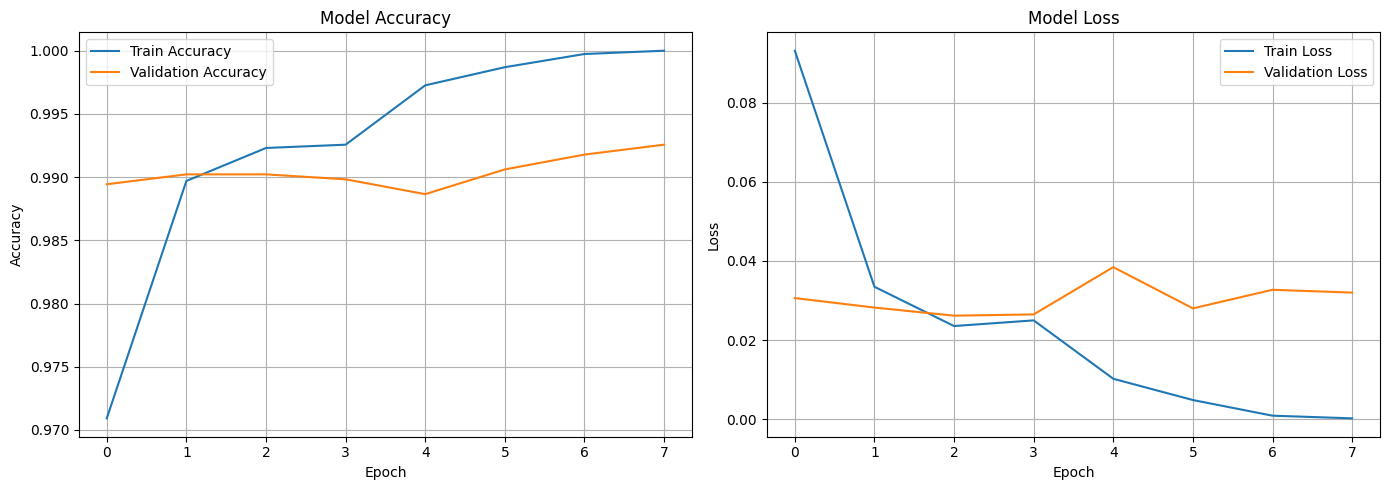

In [9]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
model.export('saved_model')
print("Model disimpan dalam format TensorFlow SavedModel.")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139857564389040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563789440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563790496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563788912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563789088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563888096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563912144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563913024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563910736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563910912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857563928704

## Konversi Model

In [12]:
tfjs.converters.save_keras_model(model, 'tfjs_model')
print("Model disimpan dalam format TensorFlow.js.")

failed to lookup keras version from the file,
    this is likely a weight only file
Model disimpan dalam format TensorFlow.js.


In [18]:
if not os.path.exists('tflite'):
    os.makedirs('tflite')
    
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model disimpan dalam format TensorFlow Lite.")

W0000 00:00:1745220726.741778   69983 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745220726.742435   69983 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-21 14:32:06.750755: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-21 14:32:06.775253: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-21 14:32:06.775284: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model
2025-04-21 14:32:06.940457: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-21 14:32:07.871624: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model
2025-04-21 14:32:08.089369: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1339137 microseconds.


Model disimpan dalam format TensorFlow Lite.


## Inference (Optional)

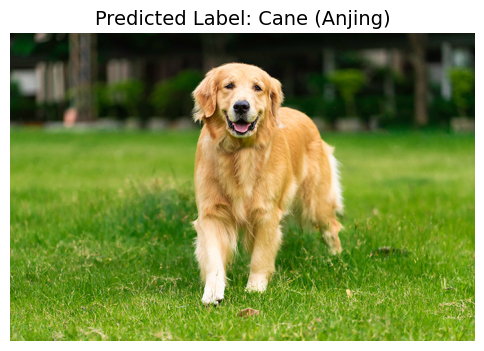

File: /home/bagus/Testing.jpg
Predicted index: 0
Predicted label: Cane (Anjing)


In [24]:
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title="Pilih Gambar") 
    
    if file_path:
        input_data = preprocess_image(file_path)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        predicted_index = np.argmax(output_data)
        predicted_label = labels[predicted_index]
        
        img = Image.open(file_path)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted Label: {predicted_label}", fontsize=14)
        plt.show()

        print("File:", file_path)
        print("Predicted index:", predicted_index)
        print("Predicted label:", predicted_label)

predict_image()